## Introduction

### In this notebook we use [UNet](https://arxiv.org/abs/1505.04597) segmentation model for performing building segmentation

### Libraries 📚⬇

In [6]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [7]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Defining train / val / test directories 📁

In [8]:
DATA_DIR = '/home/sara/Building-Segmentation-DL/data/'

# Define the paths
image_dir = '/home/sara/Building-Segmentation-DL/data/3band/'
ground_truth_dir = '/home/sara/Building-Segmentation-DL/data/buildingMaskLabels/'
text_dir = '/home/sara/Building-Segmentation-DL/data/dataSplit/'


# Define the names of the text files
text_files = ['test.txt', 'train.txt', 'val.txt']

# Define the names of the directories
dir_names = [ 'train', 'val', 'test']

# Read the text files
def split_images(image_dir, text_dir, text_files, dir_names):
    for text_file, dir_name in zip(text_files, dir_names):
        with open(os.path.join(text_dir, text_file), 'r') as file:
            image_names = file.read().splitlines()
            print(image_names)
    # Create the directory if it doesn't exist
        os.makedirs(os.path.join(image_dir, dir_name), exist_ok=True)

    # Iterate over the images in the image directory
        for image in os.listdir(image_dir):
            if image in image_names:
            # Move the image to the corresponding directory
                shutil.move(os.path.join(image_dir, image), os.path.join(image_dir, dir_name, image))

# split input images to test, train, and validation
split_images(image_dir, text_dir, text_files, dir_names)

# split ground truth images to test, train, and validation

split_images(ground_truth_dir, text_dir, text_files, dir_names)

x_train_dir = os.path.join(image_dir, dir_names[0])
y_train_dir = os.path.join(ground_truth_dir, dir_names[0])

x_valid_dir = os.path.join(image_dir, dir_names[1])
y_valid_dir = os.path.join(ground_truth_dir, dir_names[1])

x_test_dir = os.path.join(image_dir, dir_names[2])
y_test_dir = os.path.join(ground_truth_dir, dir_names[2])

['3band_AOI_1_RIO_img3962.tif', '3band_AOI_1_RIO_img6113.tif', '3band_AOI_1_RIO_img702.tif', '3band_AOI_1_RIO_img4005.tif', '3band_AOI_1_RIO_img2616.tif', '3band_AOI_1_RIO_img3225.tif', '3band_AOI_1_RIO_img4520.tif', '3band_AOI_1_RIO_img1248.tif', '3band_AOI_1_RIO_img5289.tif', '3band_AOI_1_RIO_img4056.tif', '3band_AOI_1_RIO_img795.tif', '3band_AOI_1_RIO_img5485.tif', '3band_AOI_1_RIO_img2955.tif', '3band_AOI_1_RIO_img6196.tif', '3band_AOI_1_RIO_img6385.tif', '3band_AOI_1_RIO_img6495.tif', '3band_AOI_1_RIO_img2751.tif', '3band_AOI_1_RIO_img4514.tif', '3band_AOI_1_RIO_img2727.tif', '3band_AOI_1_RIO_img6536.tif', '3band_AOI_1_RIO_img1212.tif', '3band_AOI_1_RIO_img2762.tif', '3band_AOI_1_RIO_img6323.tif', '3band_AOI_1_RIO_img6541.tif', '3band_AOI_1_RIO_img5409.tif', '3band_AOI_1_RIO_img2984.tif', '3band_AOI_1_RIO_img6823.tif', '3band_AOI_1_RIO_img6581.tif', '3band_AOI_1_RIO_img663.tif', '3band_AOI_1_RIO_img5121.tif', '3band_AOI_1_RIO_img1271.tif', '3band_AOI_1_RIO_img6191.tif', '3band_AOI

In [9]:
class_dict = pd.read_csv("./input/massachusetts-buildings-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [10]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [11]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [12]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
            type="None",
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.type = type
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
         # Resize the image to 1500 pixels
        # image = cv2.resize(image, (1500, 1500))
        # mask = cv2.resize(mask, (1500, 1500))

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.type == "training":
            image = cv2.resize(image, (416, 416))
            mask = cv2.resize(mask, (416, 416))
        if self.type == "validation":
            image = cv2.resize(image, (480, 480))
            mask = cv2.resize(mask, (480, 480))
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

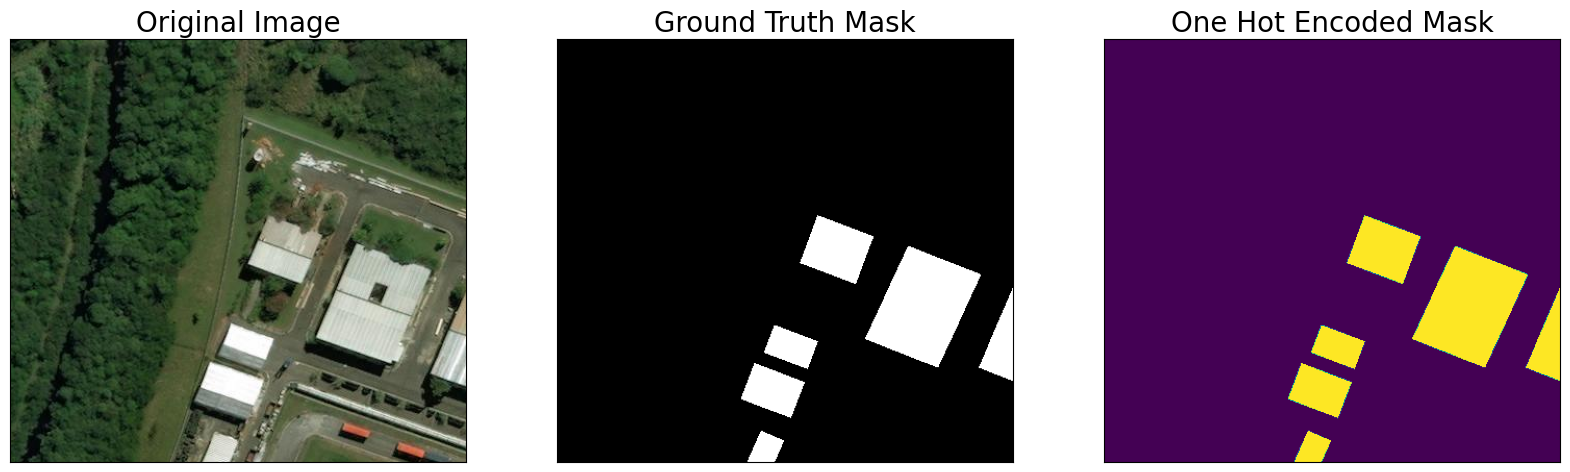

(406, 438, 3)


In [13]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values, type="None")
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

print(image.shape)

### Defining Augmentations 🙃

In [14]:
def get_training_augmentation():
    train_transform = [    
        # album.resize(256, 256),
        # album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 16
    test_transform = [
        album.PadIfNeeded(min_height=480, min_width=480, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

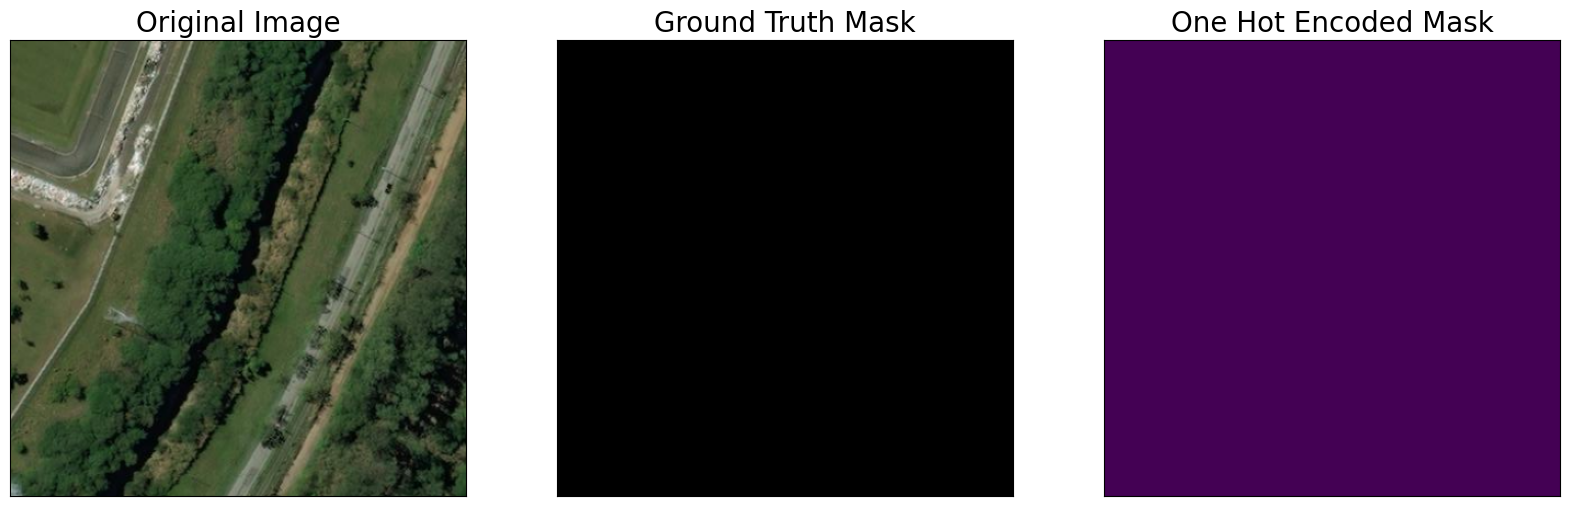

(416, 416, 3)


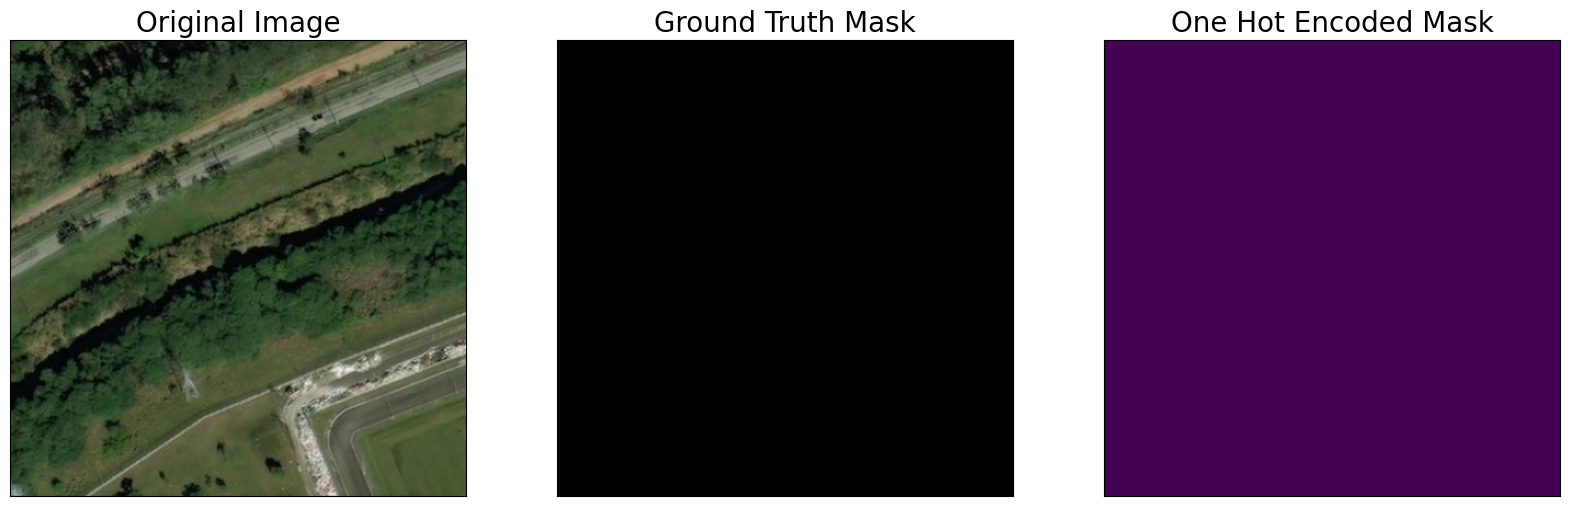

(416, 416, 3)


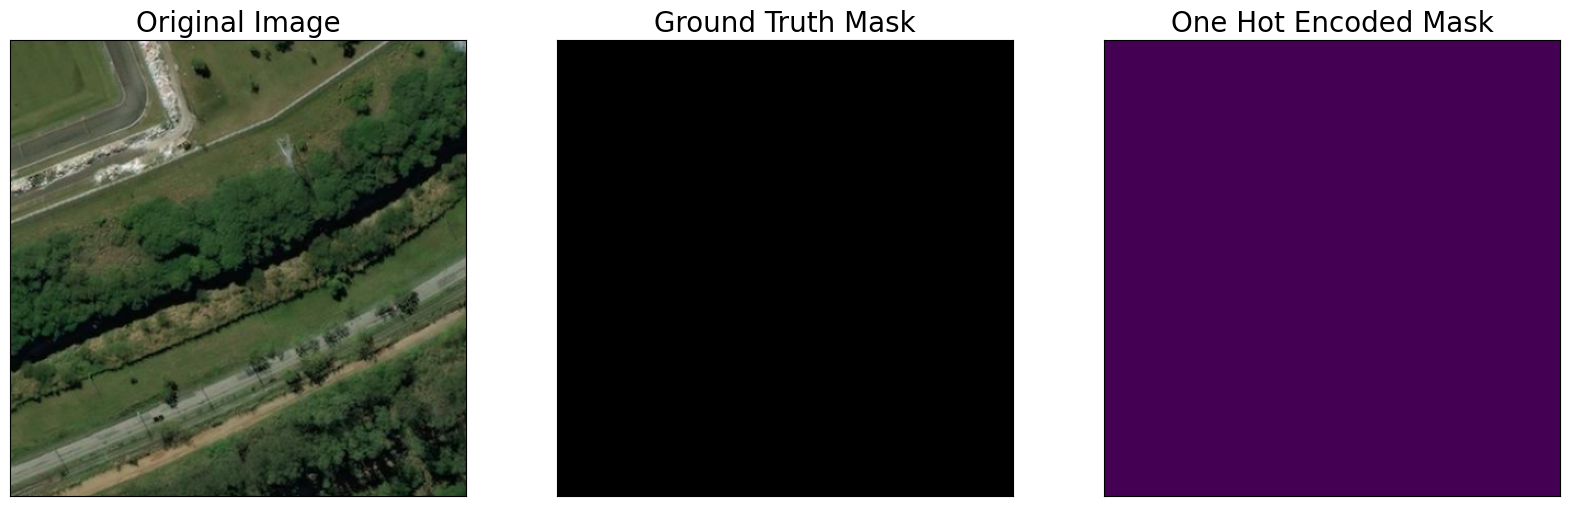

(416, 416, 3)


In [15]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
    type="training"
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )
    print(image.shape)

## Training UNet

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Model Definition

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(int(out_channels//2), out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
class SingleConv3x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleConv3x1, self).__init__()
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_out = self.single_conv(x)
        return (skip_out, skip_out)

class SingleConv4x2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleConv4x2, self).__init__()
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip_out = self.single_conv(x)
        return (skip_out, skip_out)
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        # self.down_sample = nn.MaxPool2d(1)

    def forward(self, x):
        skip_out = self.double_conv(x)
        # down_out = self.down_sample(skip_out)
        return (skip_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels))
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        # self.double_conv = DoubleConv(in_channels, out_channels)
        self.conv = SingleConv3x1(out_channels, int(out_channels//2))
        # nn.Sequential(
        #     nn.Conv2d(out_channels, int(out_channels//2), kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(int(out_channels//2)),
        #     nn.ReLU(inplace=True))

    def forward(self, skip_input, down_input):
        x = self.up_sample(torch.cat([skip_input, down_input], dim=1))
        # x = torch.cat([x, skip_input], dim=1)
        return self.conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = SingleConv3x1(3, 32)
        self.down_conv2 = SingleConv4x2(32, 64)
        self.down_conv3 = SingleConv3x1(64, 64)
        self.down_conv4 = SingleConv4x2(64, 128)
        self.down_conv5 = SingleConv3x1(128, 128)
        self.down_conv6 = SingleConv4x2(128, 256)
        self.down_conv7 = SingleConv3x1(256, 256)
        self.down_conv8 = SingleConv4x2(256, 512)

        # Bottleneck
        self.bottleneck_conv = SingleConv3x1(512, 512)

        # self.down_conv1 = DownBlock(3, 64)
        # self.down_conv2 = DownBlock(64, 128)
        # self.down_conv3 = DownBlock(128, 256)
        # self.down_conv4 = DownBlock(256, 512)
        # self.bottleneck_conv = SingleConv3x1(512, 512)
        # Upsampling Path

        self.up_conv4 = UpBlock(1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, _ = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, _ = self.down_conv4(x)
        x, skip5_out = self.down_conv5(x)
        x, _ = self.down_conv6(x)
        x, skip7_out = self.down_conv7(x)
        x, skip8_out = self.down_conv8(x)
    
        x, _ = self.bottleneck_conv(x)
        x, _ = self.up_conv4(skip8_out, x)
        # print("x shape: ", x.shape)
        x, _ = self.up_conv3(skip7_out, x)
        x, _ = self.up_conv2(skip5_out, x)
        x, _ = self.up_conv1(skip3_out, x)
        x = self.conv_last(torch.cat([skip1_out, x], dim=1))
        return x
    

# Get UNet model
model = UNet()

### Alternative UNET

In [17]:
# class UNet(nn.Module):
#     def __init__(self, class_num = 2, ignore_label = 255):
#       super(UNet, self).__init__()
#       # Define the layers
#       self.c0 = nn.Conv2d(3, 32, 3, 1, 1)
#       self.c1 = nn.Conv2d(32, 64, 4, 2, 1)
#       self.c2 = nn.Conv2d(64, 64, 3, 1, 1)
#       self.c3 = nn.Conv2d(64, 128, 4, 2, 1)
#       self.c4 = nn.Conv2d(128, 128, 3, 1, 1)
#       self.c5 = nn.Conv2d(128, 256, 4, 2, 1)
#       self.c6 = nn.Conv2d(256, 256, 3, 1, 1)
#       self.c7 = nn.Conv2d(256, 512, 4, 2, 1)
#       self.c8 = nn.Conv2d(512, 512, 3, 1, 1)
#       # Define the deconvolution layers
#       self.dc8 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
#       self.dc7 = nn.Conv2d(512, 256, 3, 1, 1)
#       self.dc6 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
#       self.dc5 = nn.Conv2d(256, 128, 3, 1, 1)
#       self.dc4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
#       self.dc3 = nn.Conv2d(128, 64, 3, 1, 1)
#       self.dc2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
#       self.dc1 = nn.Conv2d(64, 32, 3, 1, 1)
#       self.dc0 = nn.Conv2d(64, class_num, 3, 1, 1)
#       # Define the batch normalization layers
#       self.bnc0 = nn.BatchNorm2d(32)
#       self.bnc1 = nn.BatchNorm2d(64)
#       self.bnc2 = nn.BatchNorm2d(64)
#       self.bnc3 = nn.BatchNorm2d(128)
#       self.bnc4 = nn.BatchNorm2d(128)
#       self.bnc5 = nn.BatchNorm2d(256)
#       self.bnc6 = nn.BatchNorm2d(256)
#       self.bnc7 = nn.BatchNorm2d(512)
#       self.bnc8 = nn.BatchNorm2d(512)
#       self.bnd8 = nn.BatchNorm2d(512)
#       self.bnd7 = nn.BatchNorm2d(256)
#       self.bnd6 = nn.BatchNorm2d(256)
#       self.bnd5 = nn.BatchNorm2d(128)
#       self.bnd4 = nn.BatchNorm2d(128)
#       self.bnd3 = nn.BatchNorm2d(64)
#       self.bnd2 = nn.BatchNorm2d(64)
#       self.bnd1 = nn.BatchNorm2d(32)
    
#     def forward(self, x):
#       relu = nn.ReLU()
#     # Encoder
#       e0 = relu(self.bnc0(self.c0(x)))
#       e1 = relu(self.bnc1(self.c1(e0)))
#       e2 = relu(self.bnc2(self.c2(e1)))
#       del e1
#       e3 = relu(self.bnc3(self.c3(e2)))
#       e4 = relu(self.bnc4(self.c4(e3)))
#       del e3
#       e5 = relu(self.bnc5(self.c5(e4)))
#       e6 = relu(self.bnc6(self.c6(e5)))
#       del e5
#       e7 = relu(self.bnc7(self.c7(e6)))
#       e8 = relu(self.bnc8(self.c8(e7)))
#       # Decoder
#       # print("e7.shape: ",e7.shape)
#       # print("e8.shape: ",e8.shape)
#       d8 = relu(self.bnd8(self.dc8(torch.cat([e7, e8], dim=1))))
#       del e7, e8
#       d7 = relu(self.bnd7(self.dc7(d8)))
#       del d8
#       d6 = relu(self.bnd6(self.dc6(torch.cat([e6, d7], dim=1))))
#       del d7, e6
#       d5 = relu(self.bnd5(self.dc5(d6)))
#       del d6
#       d4 = relu(self.bnd4(self.dc4(torch.cat([e4, d5], dim=1))))
#       del d5, e4
#       d3 = relu(self.bnd3(self.dc3(d4)))
#       del d4
#       d2 = relu(self.bnd2(self.dc2(torch.cat([e2, d3], dim=1))))
#       del d3, e2
#       d1 = relu(self.bnd1(self.dc1(d2)))
#       del d2
#       d0 = self.dc0(torch.cat([e0, d1], dim=1))

#       return d0
# model = UNet()
# # model = smp.Unet()

#### Get Train / Val DataLoaders

In [18]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
    type="training",
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
    type="validation",
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

print(valid_dataset[0][0].shape)
print(train_dataset[0][0].shape)
print(len(train_dataset))

(3, 480, 480)
(3, 416, 416)
4858


#### Set Hyperparams

In [19]:
from segmentation_models_pytorch import utils


# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 40

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:" , DEVICE)

# define loss function
bceloss = torch.nn.BCELoss()

loss = smp.utils.losses.BCEWithLogitsLoss()
# loss = bceloss

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)

DEVICE: cuda


In [20]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [21]:
models_folder = 'models/'
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

In [27]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            # cv2.imwrite(os.path.join(models_folder, f"new_arch_{i}.pth"), model)
            torch.save(model, './models/new_arch_rerun_{}.pth'.format(i))
            print('Model saved!')


Epoch: 0
train:  30%|██▉       | 364/1215 [02:01<04:45,  2.99it/s, bce_with_logits_loss - 0.2316, iou_score - 0.8303, fscore - 0.9042, accuracy - 0.9028]


KeyboardInterrupt: 

### Prediction on Test Data

In [23]:
# load best saved model checkpoint from the current run
if os.path.exists('./models/new_arch_35.pth'):
    best_model = torch.load('./models/new_arch_35.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


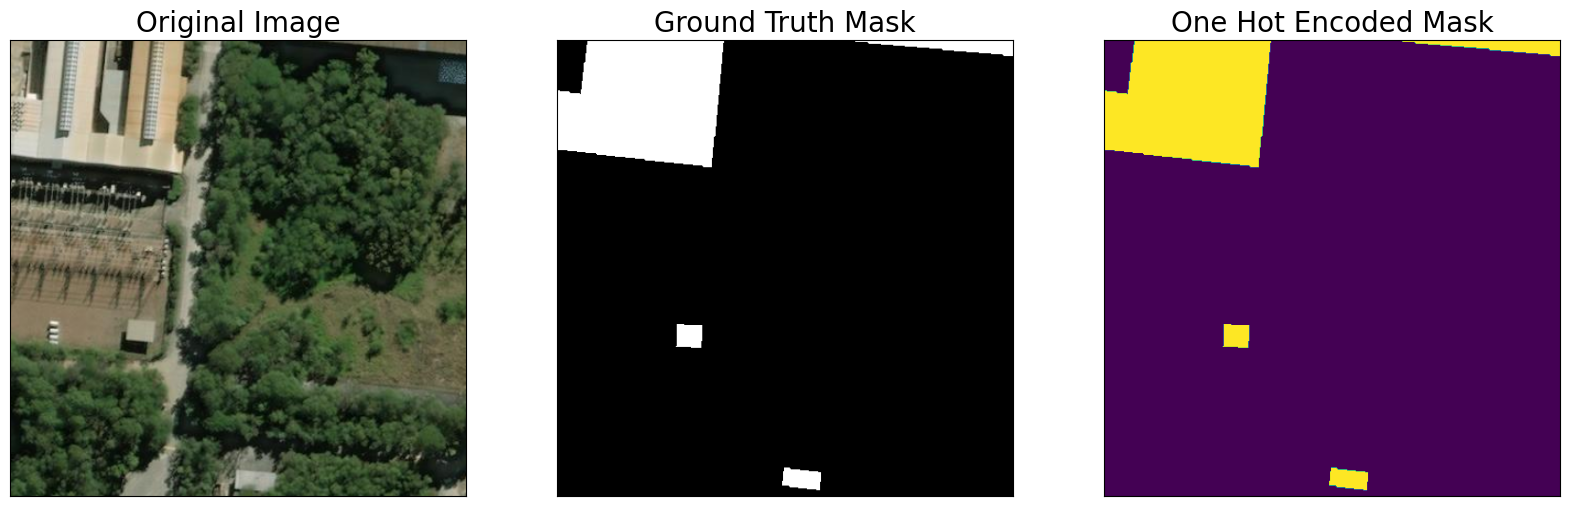

In [25]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
    type="validation",
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
    type="validation",
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [24]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'newest_arch_preds/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    random_idx = random.randint(0, len(test_dataset)-1)
    image, gt_mask = test_dataset[random_idx]
    image_vis = crop_image(test_dataset_vis[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

### Model Evaluation on Test Dataset

In [26]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['bce_with_logits_loss']:.4f}")

valid: 100%|██████████| 1388/1388 [01:20<00:00, 17.31it/s, bce_with_logits_loss - 0.6339, iou_score - 0.002111, fscore - 0.004148, accuracy - 0.4911]
Evaluation on Test Data: 
Mean IoU Score: 0.0021


KeyError: 'jaccard_loss'

### Plot Dice Loss & IoU Metric for Train vs. Val

In [28]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

""


In [29]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('new_arch_iou_score_plot.png')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'iou_score'

<Figure size 2000x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('F1 Score', fontsize=21)
plt.title('F1 Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('new_arch_f1_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.accuracy.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.accuracy.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Pixel Accuracy', fontsize=21)
plt.title('Pixel Accruracy Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('new_arch_paccuracy_plot.png')
plt.show()